In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
epoch=30
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'potato_project',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

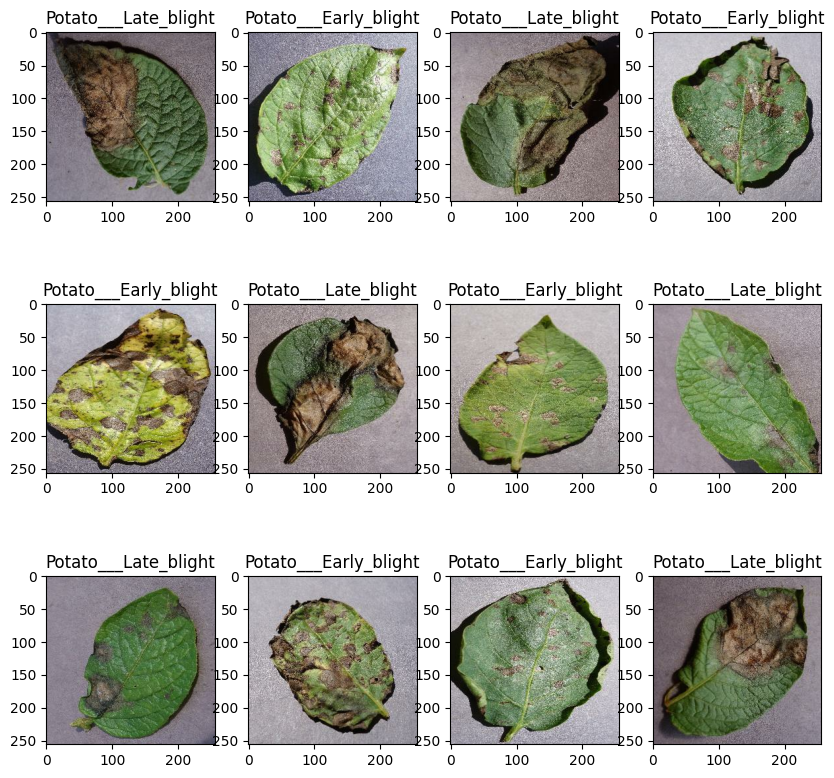

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
   for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[label_batch[i]])

In [7]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [9]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Data Preprocessing

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation(dealing with image rotation)

In [11]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Building

In [12]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),              
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')              
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history=model.fit(
    train_ds,
    epochs=epoch,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 130s 2s/step - loss: 0.9190 - accuracy: 0.4671 - val_loss: 0.7966 - val_accuracy: 0.5260
Epoch 2/30
54/54 [==============================] - 108s 2s/step - loss: 0.7427 - accuracy: 0.6344 - val_loss: 0.6587 - val_accuracy: 0.6607
Epoch 3/30
54/54 [==============================] - 106s 2s/step - loss: 0.5811 - accuracy: 0.7309 - val_loss: 0.5893 - val_accuracy: 0.6979
Epoch 4/30
54/54 [==============================] - 107s 2s/step - loss: 0.4016 - accuracy: 0.8204 - val_loss: 0.2830 - val_accuracy: 0.8854
Epoch 5/30
54/54 [==============================] - 109s 2s/step - loss: 0.3590 - accuracy: 0.8498 - val_loss: 0.3101 - val_accuracy: 0.8906
Epoch 6/30
54/54 [==============================] - 112s 2s/step - loss: 0.2887 - accuracy: 0.8809 - val_loss: 0.1810 - val_accuracy: 0.9427
Epoch 7/30
54/54 [==============================] - 112s 2s/step - loss: 0.2374 - accuracy: 0.9090 - val_loss: 0.1875 - val_accuracy: 0.9375
Epoch 8/30
54

In [16]:
score=model.evaluate(test_ds)

8/8 [==============================] - 6s 355ms/step - loss: 0.0787 - accuracy: 0.9688


In [17]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [18]:
history.history['accuracy']

[0.4671361446380615,
 0.6343896985054016,
 0.7309027910232544,
 0.8204225301742554,
 0.8497652411460876,
 0.8808685541152954,
 0.9090375304222107,
 0.9078638553619385,
 0.9102112650871277,
 0.9319248795509338,
 0.9377934336662292,
 0.9336854219436646,
 0.9436619877815247,
 0.9559859037399292,
 0.9618544578552246,
 0.9612675905227661,
 0.9694835543632507,
 0.9771126508712769,
 0.9642018675804138,
 0.9636150002479553,
 0.9589120149612427,
 0.98591548204422,
 0.9741784334182739,
 0.96772301197052,
 0.9894366264343262,
 0.9826388955116272,
 0.9872685074806213,
 0.987089216709137,
 0.9722222089767456,
 0.9882628917694092]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

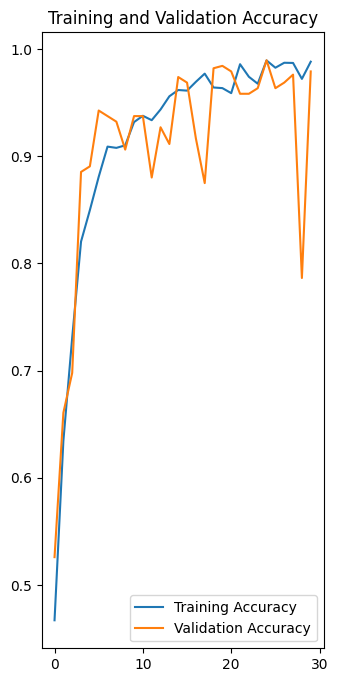

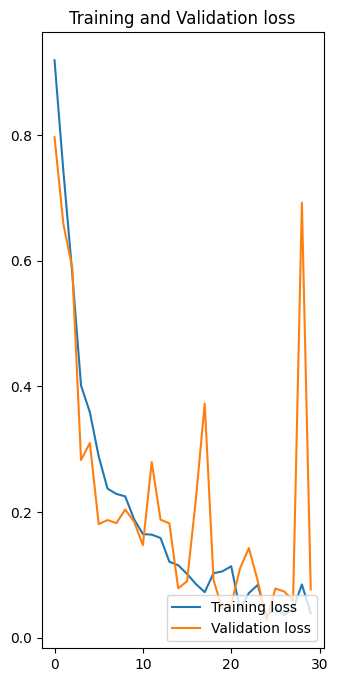

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epoch),acc,label='Training Accuracy')
plt.plot(range(epoch),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(epoch),loss,label='Training loss')
plt.plot(range(epoch),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation loss')

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 909ms/step
predicted label: Potato___Early_blight


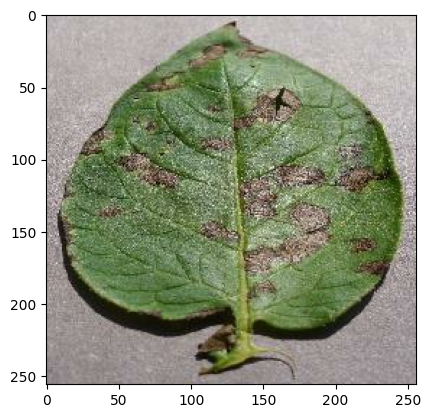

In [21]:
for image_batch,labels_batch in test_ds.take(1):
     first_image=image_batch[0].numpy().astype('uint8')
     first_label=labels_batch[0].numpy()
     print("first image to predict")
     plt.imshow(first_image)
     print("actual label:",class_name[first_label])
     batch_prediction=model.predict(image_batch)
     print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [22]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    prediction_class=class_name[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return prediction_class,confidence

1/1 [==============================] - 0s 36ms/step


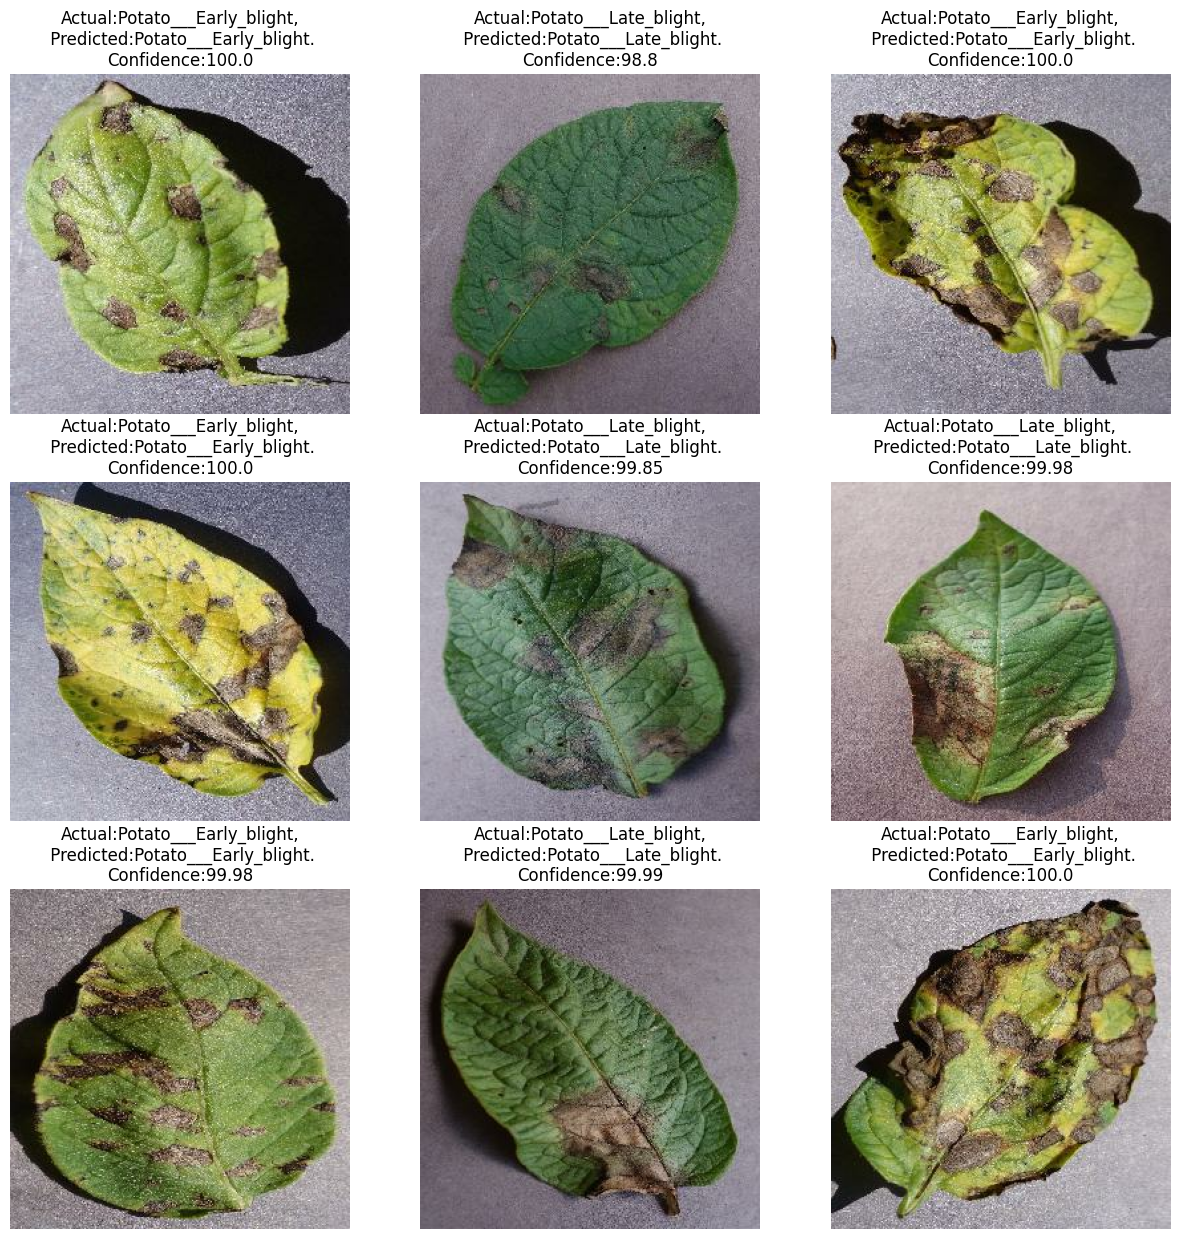

In [23]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_name[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\nConfidence:{confidence}")
        plt.axis('off')

In [24]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [25]:
import os

print(os.path.abspath("../models/1"))


c:\Users\91854\Desktop\models\1
